# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [1]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la

import pandas as pd
import seaborn as sns

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [2]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [3]:
M_train = data_train
M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k], ddof=0)
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set

print(sigma)

[  1.23328245   0.47303067   7.44601122   1.45269103   0.41684299
   1.39024269   0.70355366  29.08227243]


In [4]:
"""
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T
"""

'\n# Alternative WITHOUT FOR\nnormalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function \nM_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST\nmoy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )\nsigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )\n\nM_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T\n'

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

In [5]:
# Preliminary questions

# We are computing the autocovariance matrix of the trainning dataset containing the information about the features.
cov_matrix = np.cov(M_train[:,0:8].T, ddof=0) # ddof = 0 to force the computation using the simple average

print(cov_matrix)


# Comments
"""
The autocovariance matrix is symmetric.
We can notice the the diagonal is giving us the varaiance (the square of the standard deviation) of features.
The rest of the autocovariance matrix is telling about the covariance between the features.
The covariances values are non-zero. Thus, the features are varying together.
We can also notice that, since the features have been normalized, their variances (in the diagonal) are equal to 1, which is
the square of their standard deviation.


The 1st feature has a weak relationship with the 4th feature where the covariance is 0.063.
The 2nd feature has a weak relationship with the 7th feature where the covariance is 0.023.
The 4th feature has a weak relationship with the 8th feature where the covariance is-0.030,
and they are not varying in the same direction since their covariance is negative.

The 1st feature has a strong relationship with the 6th feature where the covariance is 0.692.
The 5th feature has a strong relationship with the 6th feature where the covariance is 0.671.
The 7th feature has a strong relationship with the 8th feature where the covariance is 0.757.
The 8th feature has a strong relationship with the 6th feature where the covariance is 0.662.

The 4th and the 5th features are stongly varying in opposite directions since the record the lowest covariance value
which is -0.139
"""

[[ 1.          0.30023199  0.28632427  0.06316772  0.59294913  0.69204308
   0.42641407  0.48316136]
 [ 0.30023199  1.          0.31672347  0.43704154  0.18105448  0.15682859
   0.02355821  0.07416632]
 [ 0.28632427  0.31672347  1.          0.28734645  0.12890226  0.1729514
   0.36591512  0.27580573]
 [ 0.06316772  0.43704154  0.28734645  1.         -0.1391468  -0.08853456
   0.03299215 -0.03040382]
 [ 0.59294913  0.18105448  0.12890226 -0.1391468   1.          0.67124021
   0.30687537  0.48135774]
 [ 0.69204308  0.15682859  0.1729514  -0.08853456  0.67124021  1.
   0.47643684  0.66253335]
 [ 0.42641407  0.02355821  0.36591512  0.03299215  0.30687537  0.47643684
   1.          0.7570565 ]
 [ 0.48316136  0.07416632  0.27580573 -0.03040382  0.48135774  0.66253335
   0.7570565   1.        ]]


'\nThe autocovariance matrix is symmetric.\nWe can notice the the diagonal is giving us the varaiance (the square of the standard deviation) of features.\nThe rest of the autocovariance matrix is telling about the covariance between the features.\nThe covariances values are non-zero. Thus, the features are varying together.\nWe can also notice that, since the features have been normalized, their variances (in the diagonal) are equal to 1, which is\nthe square of their standard deviation.\n\n\nThe 1st feature has a weak relationship with the 4th feature where the covariance is 0.063.\nThe 2nd feature has a weak relationship with the 7th feature where the covariance is 0.023.\nThe 4th feature has a weak relationship with the 8th feature where the covariance is-0.030,\nand they are not varying in the same direction since their covariance is negative.\n\nThe 1st feature has a strong relationship with the 6th feature where the covariance is 0.692.\nThe 5th feature has a strong relationship 

In [6]:
# We can also compute the coviance matrix of the features of the training dataset with the following formula:

cov_matrix = M_train[:,0:8].T.dot(M_train[:,0:8])/M_train.shape[0]

print(cov_matrix)

[[ 1.          0.30023199  0.28632427  0.06316772  0.59294913  0.69204308
   0.42641407  0.48316136]
 [ 0.30023199  1.          0.31672347  0.43704154  0.18105448  0.15682859
   0.02355821  0.07416632]
 [ 0.28632427  0.31672347  1.          0.28734645  0.12890226  0.1729514
   0.36591512  0.27580573]
 [ 0.06316772  0.43704154  0.28734645  1.         -0.1391468  -0.08853456
   0.03299215 -0.03040382]
 [ 0.59294913  0.18105448  0.12890226 -0.1391468   1.          0.67124021
   0.30687537  0.48135774]
 [ 0.69204308  0.15682859  0.1729514  -0.08853456  0.67124021  1.
   0.47643684  0.66253335]
 [ 0.42641407  0.02355821  0.36591512  0.03299215  0.30687537  0.47643684
   1.          0.7570565 ]
 [ 0.48316136  0.07416632  0.27580573 -0.03040382  0.48135774  0.66253335
   0.7570565   1.        ]]


Quelques rappels à propos de la notion de covariance : https://fr.wikipedia.org/wiki/Covariance

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [7]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

In [8]:
# Exercise 1

# Build the matrix of features X_train
t_train = data_train[:,8]   # target column
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train,1)), M_train[:,0:8]), axis=1)

In [9]:
# Estimate the regression vector beta_hat (estimates= X*beta_hat)

beta_hat =np.matmul(inv(np.matmul(X_train.T,(X_train))),np.matmul(X_train.T,t_train))
print("The regression vector beta_hat is "+str(beta_hat))

The regression vector beta_hat is [ 2.45234509  0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025
 -0.28684075 -0.02075686  0.27526843]


In [10]:
# What is the value of the first coefficient beta_hat[0] ? What does it correspond to ?
print("The value of the first coefficient of beta_hat is "+str(beta_hat[0]))

"""
This value corresponds to the intercept or the bias. It is a constant value that represent the mean value of the target.
"""

The value of the first coefficient of beta_hat is 2.45234508507


'\nThis value corresponds to the intercept or the bias. It is a constant value that represent the mean value of the target.\n'

In [11]:
# Estimate the prediction error (quadratic error) from the test set.
estimates = np.matmul(X_test,beta_hat)

# Computation of Mean Squared Error (MSE)
MSE = np.mean(np.square(t_test - estimates))

print("The prediction error is "+str(MSE))

The prediction error is 0.521274005508


## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [12]:
# Exercise 2

# Compute the Z-scores and select the most significant entries.

# Computation of sigma_hat
t_hat_train = np.matmul(X_train,beta_hat) #Computed on the training set
p = 8 # the number of features
Sigma_square_hat = 1/(N_train-p-1)*np.sum(np.square(t_train-t_hat_train)) 
sigma_hat = np.sqrt(Sigma_square_hat)

In [13]:
# Extraction of the diagonal of the matrix (X^T.X)^-1
vXX = np.diag(inv(X_train.T.dot(X_train)),k=0)

In [14]:
# Computation of the Z-scores

Z_scores = beta_hat/(sigma_hat*np.sqrt(vXX))

In [15]:
# We will consider that the null hypothesis of  βj  is rejected with probability 95% if the Z-score is greater than 2.
print("The Z-score is given by "+str(np.abs(Z_scores)))

"""
Therefore, we can select the 1st, the 2nd, the 4th and the 5th features + the intercept for predictions.
Because their Z-scores are higher than 2.
This is a direct consequense of the following assumption: "the null hypothesis of Beta_j is rejected with probanility of
95% if the Z-score is greater than 2." 

With a confidence level of 95% we can affirm that there is no statistical significance to proof a relationship between features 
3, 6, 7, 8 with respect to the target variable. Hence, they we can their B hats zero.

"""

The Z-score is given by [ 28.18152744   5.36629046   2.75078939   1.39590898   2.05584563
   2.46925518   1.86691264   0.14668121   1.73783972]


'\nTherefore, we can select the 1st, the 2nd, the 4th and the 5th features + the intercept for predictions.\nBecause their Z-scores are higher than 2.\nThis is a direct consequense of the following assumption: "the null hypothesis of Beta_j is rejected with probanility of\n95% if the Z-score is greater than 2." \n\nWith a confidence level of 95% we can affirm that there is no statistical significance to proof a relationship between features \n3, 6, 7, 8 with respect to the target variable. Hence, they we can their B hats zero.\n\n'

Estimate the prediction error over the test set if only these significant entries are taken into account for regression by putting other regression coefficients to zero.

In [16]:
# Estimate the new regression vector when only the significant features are taken into account.
# New beta_hat: Selection of the most significant features

beta_hat_new = np.array([beta_hat[0], beta_hat[1], beta_hat[2], 0, beta_hat[4], beta_hat[5], 0, 0, 0])
print("The new regression vector beta_hat_new is "+str(beta_hat_new))

The new regression vector beta_hat_new is [ 2.45234509  0.71104059  0.29045029  0.          0.21041951  0.30730025
  0.          0.          0.        ]


In [17]:
# Computation of the new estimate of the target vector with the new regression vector when only the significant features are taken into account.
estimates_new = np.matmul(X_test,beta_hat_new)

In [18]:
# Computation of the new Mean Squared Error (MSE_new)
MSE_new = np.mean(np.square(t_test - estimates_new))

print("The new prediction error is "+str(MSE_new))

The new prediction error is 0.452226616073


In [19]:
# Compare to the previous results (Exercise 1).

print("In the Exercise 1, the MSE is "+str(MSE))
print("In Exercise 2, after features selection, the MSE is "+str(MSE_new)+", which is smaller than the one of Exercise 1")
print("Therefore, one can say that features selection with z-score improved the prediction error! And the predictor is more robust !")

In the Exercise 1, the MSE is 0.521274005508
In Exercise 2, after features selection, the MSE is 0.452226616073, which is smaller than the one of Exercise 1
Therefore, one can say that features selection with z-score improved the prediction error! And the predictor is more robust !


# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [20]:
"""
t = data_train[:,8]   # column of targets
t0 = np.mean(t)

N_test = data_test.shape[0]
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  
# Here the 1st column of X_test is a column of ones.
t_hat_reg = X_test.dot(beta_hat_reg)
"""

'\nt = data_train[:,8]   # column of targets\nt0 = np.mean(t)\n\nN_test = data_test.shape[0]\nX_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  \n# Here the 1st column of X_test is a column of ones.\nt_hat_reg = X_test.dot(beta_hat_reg)\n'

In [21]:
# Exercise 3
# Center the target
t = data_train[:,8]   # column of targets
t0 = np.mean(t) # The mean of the targets. This value is the same as beta_hat[0]
tc = t - t0 # Centering the targets

In [22]:
# Normalize the features: The features where already normalize within M_train
Xc_train = M_train[:,0:8]

In [23]:
Lambda = 25 # The regularization term

beta_hat_rg = inv(Lambda*np.identity(p) + Xc_train.T.dot(Xc_train)).dot(Xc_train.T).dot(tc)

In [24]:
# The ridge regression vector is therefore:

beta_hat_reg = np.hstack((beta_hat[0], beta_hat_rg[0:8]))

print("The ridge regression vector is "+str(beta_hat_reg))
print("The regression vector of Exercise 1 is "+str(beta_hat))
print("The regression vector of Exercise 2, after features selection, is "+str(beta_hat_new))

print("The main common point between the above regression vectors is the intercept/the bias which is the same !")
print("We can notice as well that some coefficients increased and other decreased.")
print("We can notice that even if we are using different estimators, the beta_hats from both of the ridge regression and"+
      "the simple least square regression maintain some consistency regarding which features are the least important.")



The ridge regression vector is [ 2.45234509  0.4221092   0.24879171 -0.04226499  0.16575364  0.23091485
  0.01066329  0.04306017  0.13151316]
The regression vector of Exercise 1 is [ 2.45234509  0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025
 -0.28684075 -0.02075686  0.27526843]
The regression vector of Exercise 2, after features selection, is [ 2.45234509  0.71104059  0.29045029  0.          0.21041951  0.30730025
  0.          0.          0.        ]
The main common point between the above regression vectors is the intercept/the bias which is the same !
We can notice as well that some coefficients increased and other decreased.
We can notice that even if we are using different estimators, the beta_hats from both of the ridge regression andthe simple least square regression maintain some consistency regarding which features are the least important.


In [25]:
# Estimate the prediction error from the test set.

# Estimation of the prediction over test data
N_test = data_test.shape[0]
Xc_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8])) # From M_test, the test data are already normalized.

t_hat_reg_test = X_test.dot(beta_hat_reg)

# Computation of the Mean Squared Error in ridge regression (MSE_reg)
MSE_reg = np.mean(np.square(t_test - t_hat_reg_test))

print("The prediction error in ridge regression is "+str(MSE_reg)+".")
print("The error in ridge regression is lower than in regular regression (Exercise 1), and higher than the one after features selection in Exercise 2.")


The prediction error in ridge regression is 0.493942159912.
The error in ridge regression is lower than in regular regression (Exercise 1), and higher than the one after features selection in Exercise 2.


In [26]:
# Estimation of the prediction error over test data with the best regression vector
beta_best = np.array([ 2.477,  0.74 ,  0.316, 0.0,  0.0, 0.0,  0.0,  0.0,  0.0])

t_hat_best_test = Xc_test.dot(beta_hat_reg)
MSE_best = np.mean(np.square(t_test - t_hat_best_test))

print("The prediction error with the best regression vector is "+str(MSE_best)+".")


The prediction error with the best regression vector is 0.493942159912.


In [27]:
MSE_best-MSE_reg

0.0

In [28]:
# You may also compare these results to the result of best subset selection
print("It appears that the prediction with the best regession vector gives the same mean squared error as the ridge regression vector.")

It appears that the prediction with the best regession vector gives the same mean squared error as the ridge regression vector.


# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [29]:
lmax = 40
lambda_pos = arange(0,lmax+1) 

N_test = 10
m=np.zeros(8) # Initialization of the mean
s = np.zeros(8) # Initialization of the standard deviation
X_traink = np.zeros((X_train.shape[0]-N_test,8)) # Initialization of the training set
X_testk = np.zeros((N_test,8)) # Initialization of the test set
erreur = np.zeros((6,lmax+1)) # Initialization of the error matrix
erreur_rel = np.zeros((6,lmax+1)) # Initialization of the relative error matrix

In [30]:
# Exercise 4 

# Shuffling the dataset first
# import random
# random.shuffle(data_train) # Randomly shuffle the arrays of the dataset

for p in range(6):   # loop on test subsets
    # extraction of testset
    testset  = data_train[arange(p*N_test,(p+1)*N_test),0:9] 
    # extraction of trainset
    trainset = data_train[hstack((arange(p*N_test),arange((p+1)*N_test,data_train.shape[0]))),0:9]
    # Center the target
    target_train = trainset[:,8]  # column of targets
    target0 = np.mean(target_train) # The mean of the targets.
    targetc = target_train - target0 # The targets of the train set are centered
    # Normalization of entries, features
    for i in range(8): # 8 columns of entries
        m[i]=np.mean(trainset[:,i])
        s[i] = np.std(trainset[:,i], ddof=0)
        X_traink[:,i] = (trainset[:,i]-m[i])/s[i] # normalized: centered, variance 1
        X_testk[:,i] = (testset[:,i]-m[i])/s[i]   # same normalization for test set
    for lambda_p in range(lmax+1): # 40 options of lambda
        beta_hat_cv = inv(lambda_p*np.identity(8) + X_traink.T.dot(X_traink)).dot(X_traink.T).dot(targetc)
        X_test_cv = np.hstack((np.ones((N_test,1)), X_testk[:,0:8]))
        
        beta_hat_reg_cv = np.hstack((beta_hat[0], beta_hat_cv[0:8]))
        t_hat_cv_test = X_test_cv.dot(beta_hat_reg_cv)
        # Computation of the Mean Squared Error in ridge regression (erreur)
        erreur[p,lambda_p] = np.mean(np.square(testset[:,8] - t_hat_cv_test))
print(erreur)

[[ 1.04820039  1.07555701  1.10176217  1.1269283   1.15115733  1.17453933
   1.19715304  1.219067    1.24034084  1.26102657  1.28116963  1.30080991
   1.31998256  1.33871867  1.35704586  1.37498878  1.39256952  1.40980794
   1.42672197  1.44332786  1.45964039  1.47567306  1.49143822  1.50694722
   1.52221049  1.53723772  1.55203782  1.56661913  1.58098936  1.59515575
   1.60912503  1.62290355  1.63649724  1.64991171  1.66315222  1.67622375
   1.68913103  1.70187851  1.71447044  1.72691084  1.73920355]
 [ 0.32536477  0.30984217  0.29763909  0.28786152  0.27990441  0.27334495
   0.2678796   0.26328534  0.25939497  0.25608096  0.25324447  0.25080785
   0.24870933  0.24689923  0.24533713  0.24398991  0.24283014  0.24183492
   0.24098504  0.24026422  0.23965858  0.23915626  0.23874701  0.23842196
   0.23817338  0.2379945   0.23787937  0.23782274  0.23781996  0.23786686
   0.23795974  0.23809529  0.23827049  0.23848265  0.23872931  0.23900825
   0.23931744  0.23965502  0.24001929  0.24040868

In [31]:
# Exercise 4 ---------------

# Averaged error on the 6 training/test sets on each lambda ?
erreur_lambda=np.zeros(lmax+1)
std_erreur_lambda=np.zeros(lmax+1)

for j in range(lmax+1):
    erreur_lambda[j] = np.mean(erreur[:,j])
    std_erreur_lambda[j] = np.std(erreur[:,j], ddof=0) # ddof = 0 to force the computation using the simple average
print("The averaged error on the 6 training/test sets of each lambda is "+str(erreur_lambda))
print("The averaged standard deviation of the 6 training/test sets for each lambda is "+str(std_erreur_lambda))

# Relative error on the 6 training/test sets ?
for p in range(6):
    for lambda_p in range(lmax+1):
        erreur_rel[p,lambda_p] = 100*np.abs(erreur[p,lambda_p] - erreur_lambda[lambda_p])/erreur_lambda[lambda_p]
print("The relative error for each lambda value is "+str(erreur_rel))


# Averaged relative error on the 6 training/test sets ?
erreur_rel_lambda=np.zeros(lmax+1)
for n in range(lmax+1):
    erreur_rel_lambda[n] = np.mean(erreur_rel[:,n])
print("The averaged relative error for each lambda value over the 6 training/test sets is "+str(erreur_rel_lambda))


The averaged error on the 6 training/test sets of each lambda is [ 0.6722878   0.65674624  0.64607875  0.63837951  0.63260394  0.62813869
  0.62460347  0.62175167  0.61941734  0.6174852   0.61587291  0.61452023
  0.61338214  0.61242429  0.61162003  0.61094832  0.61039233  0.60993837
  0.60957518  0.60929337  0.60908505  0.60894349  0.6088629   0.60883828
  0.60886523  0.60893989  0.60905884  0.60921901  0.60941765  0.60965228
  0.60992064  0.61022068  0.61055051  0.61090841  0.61129278  0.61170214
  0.61213513  0.61259046  0.61306697  0.61356353  0.6140791 ]
The averaged standard deviation of the 6 training/test sets for each lambda is [ 0.3109947   0.30509309  0.30507868  0.30797329  0.31238065  0.31760446
  0.32327955  0.32920637  0.33527193  0.34141023  0.34758155  0.35376125
  0.35993349  0.36608777  0.37221677  0.37831523  0.38437917  0.39040549
  0.39639169  0.4023357   0.40823577  0.41409044  0.41989846  0.42565878
  0.43137051  0.43703292  0.4426454   0.4482075   0.45371884  0.

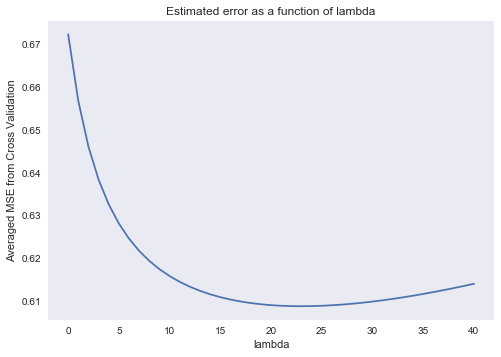

In [32]:
# Exercise 4 FIGURE ---------------
# Plotting the Estimated averaged error as a function of lambda

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(lambda_pos, erreur_lambda.T)

ax.set(xlabel='lambda', ylabel='Averaged MSE from Cross Validation',
       title='Estimated error as a function of lambda')
ax.grid()

fig.savefig("Lambda_MSE.png")
plt.show()


In [34]:
# choice of lambda that minimizes the error

i, = np.where(np.isclose(erreur_lambda, np.min(erreur_lambda))) # floating-point

print("The lambda that minimizes the error is "+str(i))

The lambda that minimizes the error is [23]


In [35]:
"""
Therefore, the lambda that minimizes the mean square error is equal to 23 (in the interval between 0 and 40).
"""

'\nTherefore, the lambda that minimizes the mean square error is equal to 23 (in the interval between 0 and 40).\n'

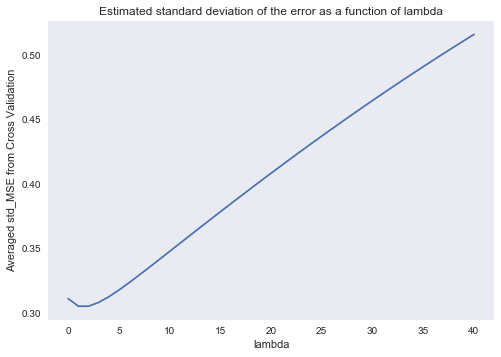

In [36]:
# Exercise 4 (continued)

# Plotting the averaged standard deviation as a function of lambda

fig, ax = plt.subplots()
ax.plot(lambda_pos, std_erreur_lambda.T)

ax.set(xlabel='lambda', ylabel='Averaged std_MSE from Cross Validation',
       title='Estimated standard deviation of the error as a function of lambda')
ax.grid()

fig.savefig("Lambda_std.png")
plt.show()


In [37]:
i_std, = np.where(np.isclose(std_erreur_lambda, np.min(std_erreur_lambda))) # floating-point

print("The lambda that minimizes the standard deviation of the error is "+str(i_std))

The lambda that minimizes the standard deviation of the error is [2]


In [38]:
"""
Except for lambda between 0 and 3, the standard deviation of the mean squared error is increasing when lambda increases.
We can notice that the lamda of the minimum error that not corresponds to the one of the minimum standard deviation.
"""

'\nExcept for lambda between 0 and 3, the standard deviation of the mean squared error is increasing when lambda increases.\nWe can notice that the lamda of the minimum error that not corresponds to the one of the minimum standard deviation.\n'

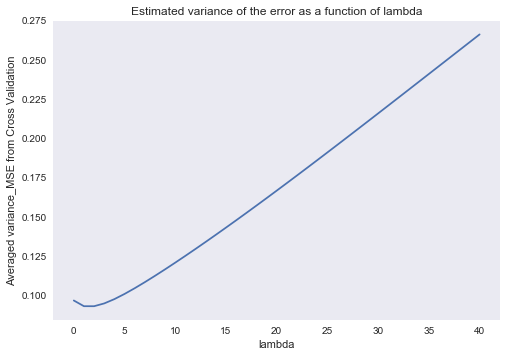

In [39]:
# Exercise 4 (continued)

# Plotting the averaged variance as a function of lambda
# We compute the variance as the square of the standard deviation

fig, ax = plt.subplots()
ax.plot(lambda_pos, np.square(std_erreur_lambda.T))

ax.set(xlabel='lambda', ylabel='Averaged variance_MSE from Cross Validation',
       title='Estimated variance of the error as a function of lambda')
ax.grid()

fig.savefig("Lambda_variance.png")
plt.show()

In [40]:
i_var, = np.where(np.isclose(np.square(std_erreur_lambda), np.min(np.square(std_erreur_lambda)))) # floating-point

print("The lambda that minimizes the variance of the error is "+str(i_var))

The lambda that minimizes the variance of the error is [2]


In [41]:
"""
As for standard deviation of the error, the variance of the mean squared error is increasing when lambda increases.
We can notice that the lambda that minimizes the error is not the same as the one minimizes the variance.
"""

'\nAs for standard deviation of the error, the variance of the mean squared error is increasing when lambda increases.\nWe can notice that the lambda that minimizes the error is not the same as the one minimizes the variance.\n'

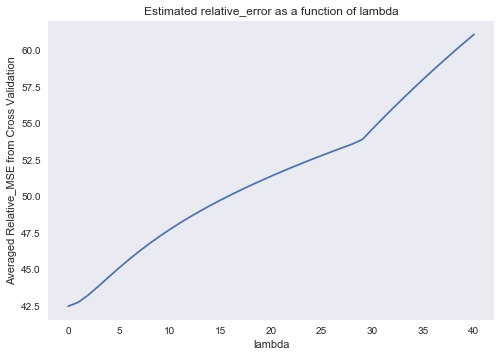

In [42]:
# Exercise 4 (continued)

# Plotting the Estimated relative error as a function of lambda

fig, ax = plt.subplots()
ax.plot(lambda_pos, erreur_rel_lambda.T)

ax.set(xlabel='lambda', ylabel='Averaged Relative_MSE from Cross Validation',
       title='Estimated relative_error as a function of lambda')
ax.grid()

fig.savefig("Lambda_rel_error.png")
plt.show()


In [43]:
"""
We can notice that the averaged relative error is also increasing when lambda increases.
"""

'\nWe can notice that the averaged relative error is also increasing when lambda increases.\n'